In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [28]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802'
all_files = glob.glob(os.path.join(path, "*.json"))

In [29]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [30]:
for types in df.type.unique():
    print(types)
    

Checkout
Oper
Voided
Va
EBT
Tndr
Dept
Reprint


In [31]:
for term in df.term.unique():
    print(term)
    

11
6
10
5
8
1
3
4
2
7
9


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [32]:
df=df[df['term']<10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67903 entries, 9 to 3036
Data columns (total 10 columns):
date      67903 non-null object
gross+    67903 non-null float64
gross-    67903 non-null float64
items     67903 non-null object
net       67903 non-null float64
oper      67903 non-null int64
term      67903 non-null int64
time      67903 non-null object
trans     67903 non-null int64
type      67903 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 5.7+ MB


In [33]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [34]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [9]:
pickle.dump(df,open('./pickles/df2018.p','wb'))

In [12]:
df = pickle.load(open('./pickles/df2018.p','rb'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831284 entries, 5 to 2824
Data columns (total 12 columns):
date           831284 non-null datetime64[ns]
gross+         831284 non-null float64
gross-         831284 non-null float64
items          831284 non-null object
net            831284 non-null float64
oper           831284 non-null int64
term           831284 non-null int64
time           831284 non-null object
trans          831284 non-null int64
type           831284 non-null object
day_of_week    831284 non-null object
month          831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 82.4+ MB


In [31]:
#quarter1 = df[(df['month']>=1) & (df['month']<=3)]

## Import just one day into a dataframe 

In [9]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831284 entries, 5 to 2824
Data columns (total 12 columns):
date           831284 non-null datetime64[ns]
gross+         831284 non-null float64
gross-         831284 non-null float64
items          831284 non-null object
net            831284 non-null float64
oper           831284 non-null int64
term           831284 non-null int64
time           831284 non-null object
trans          831284 non-null int64
type           831284 non-null object
day_of_week    831284 non-null object
month          831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 82.4+ MB


In [35]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=5)

<class 'list'>


In [36]:
Counter(item_dict).most_common(25)

[('BAG CREDIT', 58430),
 ('SF Bag Charge', 15598),
 ('SMALL COOLER CRV', 12635),
 ('BANANAS', 9919),
 ('AVOCADOS HASS', 6997),
 ('ONIONS YELLOW', 6248),
 ('APPLES FUJI', 5125),
 ('8 OZ BIO TUB t3', 4985),
 ('GARLIC WHITE', 4361),
 ('CRV LRG SING NOTAX', 4087),
 ('CRV SMALL SING T', 4073),
 ('CELERY', 3722),
 ('CRV SMALL NO TAX', 3607),
 ('16OZ BIO TUB t4', 3491),
 ('PEPPERS RED BELL', 3490),
 ('KALE DINO', 3449),
 ('ORANGES NAVEL', 3426),
 ('CARROTS LOOSE', 3322),
 ('GINGER', 3216),
 ('LEMONS', 3147),
 ('BOTTLE DEPOSIT', 3088),
 ('SQUASH ZUCCHINI', 3029),
 ('LARGE COOLER CRV', 3003),
 ('CILANTRO', 2998),
 ('SATSUMA MANDARIN', 2926)]

In [37]:
df['item_count']=basket_counts

In [38]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [39]:
q1,q2,q3

(4.0, 8.0, 17.0)

In [783]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [785]:
#df = df_avg

In [10]:
df['item_count'].max()

251

In [40]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [41]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [42]:
df.index

Int64Index([   9,   15,   20,   21,   22,   23,   24,   25,   27,   28,
            ...
            3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036],
           dtype='int64', length=67903)

In [43]:
df=df.reset_index()

In [44]:
df.index

RangeIndex(start=0, stop=67903, step=1)

In [45]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items,item_count
count,67903.000000,67903.000000,67903.000000,67903.000000,67903.000000,67903.000000,67903.000000,67903.0,67903.0,67903.000000
mean,1332.511259,128.340700,3.653184,124.687516,53.272418,4.342651,155.246705,2.0,0.0,11.921520
std,775.318630,522.664879,91.514184,500.383649,27.071997,2.518374,106.784432,0.0,0.0,11.930053
min,3.000000,0.000000,0.000000,-167.520000,1.000000,1.000000,1.000000,2.0,0.0,0.000000
25%,666.000000,17.400000,0.000000,17.060000,26.000000,2.000000,69.000000,2.0,0.0,4.000000
50%,1319.000000,43.830000,0.000000,43.240000,55.000000,4.000000,141.000000,2.0,0.0,8.000000
75%,1971.000000,93.150000,0.000000,91.655000,79.000000,6.000000,224.000000,2.0,0.0,17.000000
max,3114.000000,14257.890000,7539.930000,13755.450000,104.000000,9.000000,583.000000,2.0,0.0,156.000000


In [46]:
df.pop('index')
print ()

In [47]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 14 columns):
date              67903 non-null datetime64[ns]
gross+            67903 non-null float64
gross-            67903 non-null float64
items             67903 non-null object
net               67903 non-null float64
oper              67903 non-null int64
term              67903 non-null int64
time              67903 non-null object
trans             67903 non-null int64
type              67903 non-null object
day_of_week       67903 non-null object
month             67903 non-null int64
total_of_items    67903 non-null int64
item_count        67903 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 7.3+ MB


In [48]:
df.iloc[:,0].index


RangeIndex(start=0, stop=67903, step=1)

In [49]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=67903, step=1)

In [50]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [108]:
col_index_dict['CILANTRO']

6249

In [28]:
matrix = np.zeros(df_items.shape)
matrix.shape

(72142, 14887)

In [52]:
    matrix_dict = defaultdict(int)
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            if item[1] not in stopwords:
                if item[2] > 0:
                    value = 1
                elif item[2] == 0:
                    value = 0
                else:
                    value = -1
                matrix_dict[(i,col_index_dict[item[1]])] += value #+ matrix_dict[(i,item[1])]
                #matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + value
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [53]:
len(matrix_dict)

569098

In [54]:
#[k[0] for k,v in matrix_dict.items()]

In [55]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(value)
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [2]:
import pickle

In [56]:
sparse_matrix[4]

<1x13148 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [43]:
pickle.dump(sparse_matrix,open('sparse_matrix2018.p','wb'))

In [56]:
pickle.dump(items_set,open('items_set2018.p','wb'))

In [72]:
file = open("./sparse_matrix2018.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [73]:
file = open("./items_set2018.p",'rb')
items_set = pickle.load(file)
file.close()

In [100]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [101]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(sparse_matrix.shape[0]):
    if sparse_matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

KeyboardInterrupt: 

In [102]:
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

0.0004968217841315362 % of zero weight baskets


In [ ]:
#Set all negative values in the matrix to 0.
#matrix = pickle.load('matrix.p','rb')
#matrix = (matrix > 0).astype(int)

In [103]:
matrix.shape[0]

NameError: name 'matrix' is not defined

In [104]:
sparse_matrix

<831284x31479 sparse matrix of type '<class 'numpy.int64'>'
	with 7366753 stored elements in Compressed Sparse Row format>

In [75]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [76]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [78]:
scores =[]
for i in range(1,25,5):
    iter=i
    iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
    print(iteration,score)
    scores.append([iteration,score,model_iter])

NameError: name 'scoring' is not defined

In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [79]:
#scores

In [80]:
#just_scores

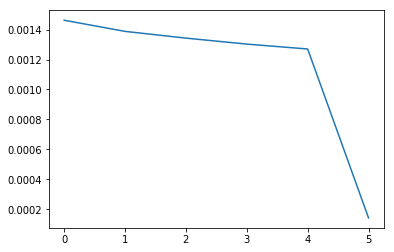

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [ ]:
rebuilt = np.dot(W,H)

In [ ]:
rebuilt.shape

In [ ]:
matrix.shape

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [81]:
def fit_NMF(sparse_matrix,n_components=2,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components=20,max_iter=250)

In [82]:
model_iter

248

In [83]:
H.shape

(20, 31479)

In [14]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
LDA_model = LDA(n_components=2,max_iter=10)
LDA_W = model.fit_transform(sparse_matrix)
LDA_H = model.components_


In [110]:
H[:,6249]

array([0.        , 0.0003763 , 0.        , 0.        , 0.        ,
       0.00036579, 0.00144758, 0.0003952 , 0.00053301, 0.000792  ,
       0.        , 0.        , 0.        , 0.00051558, 0.        ,
       0.00071066, 0.        , 0.00112745, 0.        , 0.00103051])

In [85]:
feature_names=list(items_set).copy()
n_top_words=200
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[25176 19373 20900  3576 22117   761  2008  1194 25567 15254 27725 31072
 14815 14136 24040  3104 19972  3570 18257  4757 11890 29687 24539  1501
  6306 26307 26679 23917  5405 25221 17123 22546  4544 23757  1391 24131
   462 16955 20831 14186 22130 14030 15053 14076 20675  6438 28309  2496
  8307  5875 19596 19617  5987 24133 10800  7783 10127 29562 21911 15754
 15884  2684  2814  8404 24933 25932  6359 14121 27397  4659  2339 26424
 17128  5696  3633  2936  2628 13632 13169 15388  6990 20913  7823 10156
 11876 11595  8615 29731  7602 25724  8375 14163 14454   347 15496  8564
 28641  4793 19202 29553  8290 11115  4625 21543  2414 24971  7740 15085
 20204 17556 20195 10532 13467  1892 12333 29016 12755 27926 20004  4549
 17436 17044 27353 30857 18125  5117  5821  1052  1410 18292 29837  4018
 27906  7371 24175 25303 10956 11461 18577 14670 22338 19226 13071  1873
 29471 18963  5883 21217 24629  5436  6333  3699   590 31478 16775 14956
 26458  9152 22359  8838  1947 13410 13063 29247 20

Topic #0:
['CILANTRO', 'PEPPER CHILI', 'LIMES', 'HERBS BUNCH', 'PARSLEY ITALIAN', 'TOMATOES ROMA', 'LEMONS MEYER', 'ONIONS WHITE', 'SHALLOTS', 'CABBAGE GREEN', 'LEMONGRASS', 'TOMATO MIX HEIRLOO', 'ORG Y CORN TORT', 'DILL', 'GREEN ONIONS', 'PEPPERS GREEN BELL', 'TOMATOES CLUSTER', 'ORANGES BLOOD', 'TOMATILLOS', 'FENNEL']


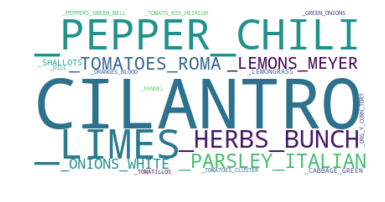

<img src="./img/2018/10/month.topic0.png">
Topic #1:
['APPLES FUJI', 'PEAR BOSC', 'KIWI LOOSE', 'ORANGES VALENCIA', 'PEARS RED', 'GRAPEFRUIT', 'TANGELO MINNEOLA', 'POTATOES JAPANESE', 'CARA CARA NAVEL', 'CUCUMBERS', 'BEETS RED LOOSE', 'MILTON CHEDDAR', 'PARADISO VINTAGE', '3185 ORG MANGO', 'ORANGES BLOOD', 'POTATOES GARNET', 'EGGS DZ ST JOHN', 'LETTUCE RED LEAF', '3080 MEDJOOL DATES', 'LETTUCE RED BUTTER']


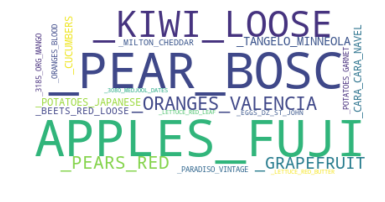

<img src="./img/2018/10/month.topic1.png">
Topic #2:
['ONIONS YELLOW', 'POTATOES YELLOW', 'POTATOES RUSSET', 'POTATOES GARNET', 'LEEKS', 'SQUASH BUTTERNUT', 'SHALLOTS', 'CAULIFLOWER CELLO', 'PEPPERS GREEN BELL', 'MILTON CHEDDAR', 'ROOTS PARSNIP', 'EGGS DZ ST JOHN', 'EGGPLANT GLOBE', '3680 BAKERS CH FLO', 'STRAUS PLN YOG QT', 'CABBAGE GREEN', 'PARMIGIANO REGG', '8036 BAY LEAF ORG', 'POTATOES FINGERLIN', 'ORG 1LB BUTTER']


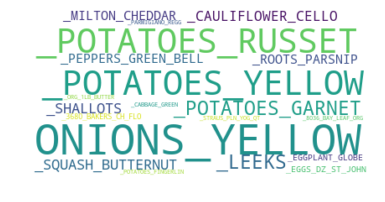

<img src="./img/2018/10/month.topic2.png">
Topic #3:
['GARLIC WHITE', 'SHALLOTS', 'ONIONS WHITE', 'MUSHROOMS SHIITAKE', 'LEMONS MEYER', 'PARMIGIANO REGG', 'EGGPLANT GLOBE', 'POTATOES RUSSET', 'POTATOES YELLOW', 'PEPPER CHILI', 'HERBS BUNCH', 'ORANGES BLOOD', 'BASIL 4oz PACKAGE', 'EGGS DZ ST JOHN', 'WHOLE ORG MILK', '4125 OG STL CUT OA', 'PARMIGIANO REGGIAN', 'MILTON CHEDDAR', 'POTATOES JAPANESE', 'LEEKS']


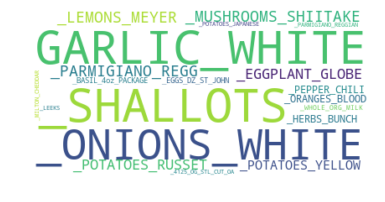

<img src="./img/2018/10/month.topic3.png">
Topic #4:
['CELERY', 'CUCUMBERS', 'PARSLEY ITALIAN', 'LEEKS', 'BEETS RED LOOSE', 'FENNEL', 'SPINACH BUNCHED', 'POTATOES YELLOW', 'ROOT TURMERIC', 'PARSLEY CURLY', 'COLLARDS', 'KALE GREEN', 'HERBS BUNCH', 'LETTUCE ROMAINE', 'CHARD RED', 'CABBAGE GREEN', 'DANDELION', 'CABBAGE RED', 'LIL GEM LETTUCE', 'ARTICHOKES']


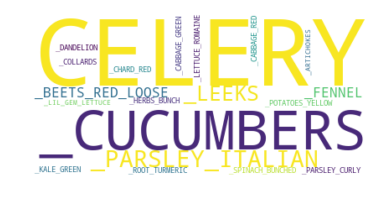

<img src="./img/2018/10/month.topic4.png">
Topic #5:
['MUSHROOM CRIMINI', 'LETTUCE SALAD MIX', 'ARUGULA LOOSE', 'POTATOES GARNET', 'SHALLOTS', 'SUGAR PLUM CLAM', 'TOMATOES ROMA', 'POTATOES RUSSET', 'MUSHROOMS SHIITAKE', '5452 ORG PNUT BUTR', 'EGGS DZ ROCK LG', 'LETTUCE RED LEAF', 'TOMATO MIX HEIRLOO', 'LEEKS', '6078 FRESH RAVIOLI', 'TOMATOES CLUSTER', 'BROCCOLI BABY SWEE', 'PARADISO VINTAGE', 'CABBAGE RED', 'SHIITAKES BABY']


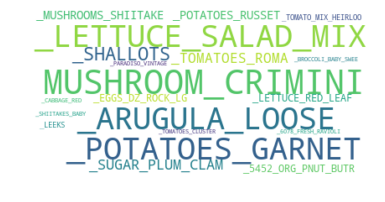

<img src="./img/2018/10/month.topic5.png">
Topic #6:
['ORANGES NAVEL', 'GRAPEFRUIT', 'PEAR BOSC', 'APPLES PINK LADY', 'APPLE HONEYCRISP', 'POTATOES GARNET', 'KIWI LOOSE', 'POTATOES RUSSET', 'MILTON CHEDDAR', 'CUCUMBERS', 'TOMATOES CLUSTER', 'LETTUCE RED LEAF', 'POTATOES YELLOW', 'ORANGES BLOOD', 'TOMATOES ROMA', 'TANGELO MINNEOLA', 'CABBAGE RED', 'LETTUCE SALAD MIX', 'ORGANIC 2% MILK', 'EGGPLANT GLOBE']


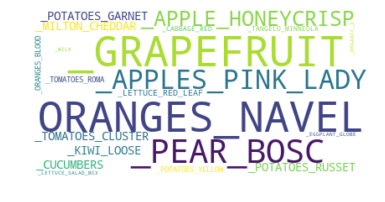

<img src="./img/2018/10/month.topic6.png">
Topic #7:
['KALE DINO', 'POTATOES GARNET', 'COLLARDS', 'CUCUMBERS', 'CHARD RED', 'BEETS RED LOOSE', 'CABBAGE RED', 'POTATOES JAPANESE', 'PARSLEY ITALIAN', 'CHARD RAINBOW', 'DANDELION', 'CAULIFLOWER CELLO', 'BROCCOLI BABY SWEE', 'KALE RED RUSSIAN', 'SQUASH BUTTERNUT', 'MUSHROOMS SHIITAKE', 'LETTUCE ROMAINE', 'KALE RED BOR', 'SQUASH DELICATA', 'BEETS RED BUNCHED']


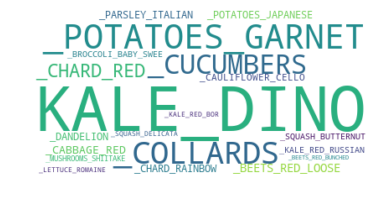

<img src="./img/2018/10/month.topic7.png">
Topic #8:
['GINGER', 'ROOT TURMERIC', 'MUSHROOMS SHIITAKE', 'POTATOES GARNET', '8571 TURM PWD ORG', 'BEETS RED LOOSE', 'PEAR BOSC', 'GARLIC PURPLE', 'BOK CHOY BABY', 'LEMONGRASS', 'LEMONS MEYER', 'SHALLOTS', 'KALE GREEN', '8160 CUMIN SD ORG', '2220 ORG RED LNTL', 'FENNEL', 'BRUSSEL SPROUTS', '5120 ORG ALMONDS', 'DAIKON', 'DANDELION']


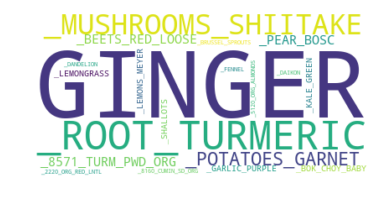

<img src="./img/2018/10/month.topic8.png">
Topic #9:
['LEMONS', 'LIMES', 'PARSLEY ITALIAN', 'CUCUMBERS', 'GRAPEFRUIT', 'HERBS BUNCH', 'SHALLOTS', 'CAULIFLOWER CELLO', 'ORANGES BLOOD', 'TOMATO MIX HEIRLOO', 'ARUGULA LOOSE', 'FENNEL', 'ORANGES VALENCIA', 'DILL', 'LETTUCE SALAD MIX', 'TANGELO MINNEOLA', 'CUCUMBERS ENGLISH', 'PARMIGIANO REGG', 'MIX CHERRY TOMATO', 'super greens']


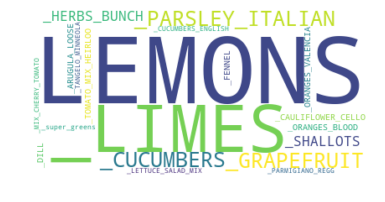

<img src="./img/2018/10/month.topic9.png">
Topic #10:
['SQUASH ZUCCHINI', 'BEANS GREEN', 'EGGPLANT GLOBE', 'POTATOES GARNET', 'CAULIFLOWER CELLO', 'POTATOES YELLOW', 'SQUASH SUNBURST', 'LEEKS', 'ASPARAGUS', 'TOMATOES ROMA', 'CHARD RED', 'CABBAGE GREEN', 'LETTUCE SALAD MIX', 'BOK CHOY BABY', 'POTATOES RED', 'BRUSSEL SPROUTS', 'PEPPERS GREEN BELL', 'PEPPERS YELLOW BEL', 'CHARD RAINBOW', 'PEAR BOSC']


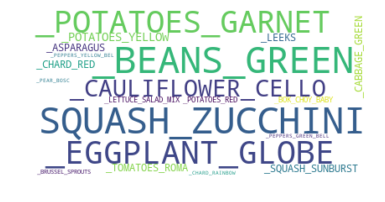

<img src="./img/2018/10/month.topic10.png">
Topic #11:
['PEPPERS RED BELL', 'PEPPERS ORANGE BEL', 'PEPPERS YELLOW BEL', 'PEPPERS GREEN BELL', 'CUCUMBERS', 'SUGAR PLUM CLAM', 'LETTUCE SALAD MIX', 'TOMATOES ROMA', 'EGGPLANT GLOBE', 'PEPPER CHILI', 'CUCUMBERS ENGLISH', 'LETTUCE RED LEAF', 'LETTUCE ROMAINE', 'PEAS SNAP', 'BEANS GREEN', 'CAULIFLOWER CELLO', 'POTATOES GARNET', 'CABBAGE RED', 'APPLES PINK LADY', 'APPLE HONEYCRISP']


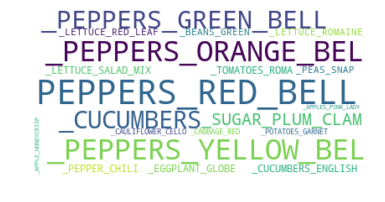

<img src="./img/2018/10/month.topic11.png">
Topic #12:
['CARROTS LOOSE', 'BEANS GREEN', 'POTATOES YELLOW', 'BEETS RED LOOSE', 'LEEKS', 'POTATOES RUSSET', 'LETTUCE SALAD MIX', 'CABBAGE GREEN', 'PEAR BOSC', 'TOMATOES ROMA', 'POTATOES GARNET', 'ROOTS PARSNIP', 'POTATOES JAPANESE', 'CABBAGE RED', 'CUCUMBERS', 'CAULIFLOWER CELLO', 'ROOTS TURNIP LOOSE', 'GRAPEFRUIT', 'POTATOES RED', 'LETTUCE RED LEAF']


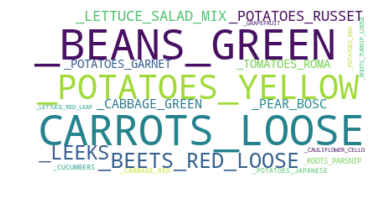

<img src="./img/2018/10/month.topic12.png">
Topic #13:
['SPINACH LOOSE', 'ARUGULA LOOSE', 'CUCUMBERS', 'SUGAR PLUM CLAM', 'LETTUCE SALAD MIX', 'POTATOES GARNET', 'APPLES PINK LADY', 'POTATOES JAPANESE', 'CAULIFLOWER CELLO', 'BRUSSEL SPROUTS', 'KALE GREEN', 'TOMATOES CLUSTER', 'APPLE HONEYCRISP', 'STRAWBERRY 1LB PKG', 'BOK CHOY BABY', 'BROCCOLI BABY SWEE', 'PEARS RED', 'CARROTS BABY', '5452 ORG PNUT BUTR', 'TOMATOES ROMA']


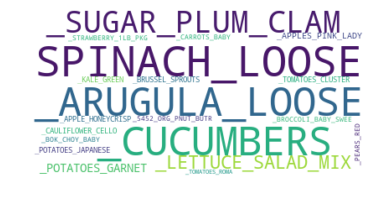

<img src="./img/2018/10/month.topic13.png">
Topic #14:
['ONIONS RED', 'POTATOES GARNET', 'TOMATOES ROMA', 'TOMATO MIX HEIRLOO', 'CABBAGE RED', 'SUGAR PLUM CLAM', 'ONIONS WHITE', 'POTATOES YELLOW', 'TOMATOES CLUSTER', 'PARSLEY ITALIAN', 'EGGPLANT GLOBE', 'MIX CHERRY TOMATO', 'DILL', 'MUSHROOMS SHIITAKE', 'BEETS RED LOOSE', 'HERBS BUNCH', 'BROCCOLI BABY SWEE', 'PEPPERS GREEN BELL', 'ARUGULA LOOSE', 'LETTUCE ROMAINE']


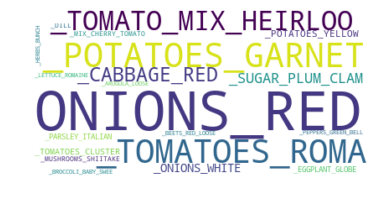

<img src="./img/2018/10/month.topic14.png">
Topic #15:
['BROCCOLI LOOSE', 'POTATOES GARNET', 'CAULIFLOWER CELLO', 'POTATOES RUSSET', 'BEANS GREEN', 'CABBAGE RED', 'BRUSSEL SPROUTS', 'LETTUCE RED LEAF', 'PEAR BOSC', 'CABBAGE GREEN', 'KALE GREEN', 'BEETS RED LOOSE', 'CAULIFLOWER BULK', 'APPLES PINK LADY', 'CHARD RED', 'SPINACH BUNCHED', 'ORANGES VALENCIA', 'PEAS SNAP', 'MUSHROOMS SHIITAKE', 'TOMATOES ROMA']


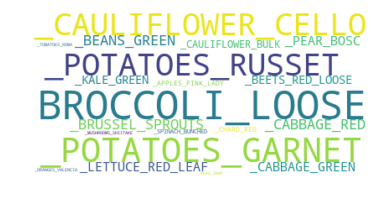

<img src="./img/2018/10/month.topic15.png">
Topic #16:
['ONIONS GREEN', 'PARSLEY ITALIAN', 'HERBS BUNCH', 'MUSHROOMS SHIITAKE', 'ARUGULA LOOSE', 'SUGAR PLUM CLAM', 'BOK CHOY BABY', 'CAULIFLOWER CELLO', 'SHALLOTS', 'DILL', 'LEEKS', 'CABBAGE NAPA', 'FENNEL', 'DAIKON', 'POTATOES RUSSET', 'LETTUCE RED LEAF', 'CABBAGE GREEN', 'RADDICHIO', 'MUNG BEAN SPROUT', 'CUCUMBERS ENGLISH']


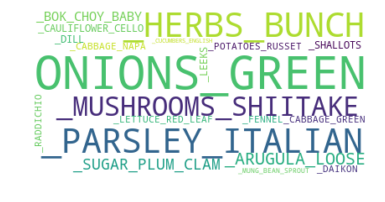

<img src="./img/2018/10/month.topic16.png">
Topic #17:
['SATSUMA MANDARIN', 'PEAR BOSC', 'KIWI LOOSE', 'GRAPEFRUIT', 'ORANGES BLOOD', 'CARA CARA NAVEL', 'PARADISO VINTAGE', 'APPLES PINK LADY', 'POTATOES YELLOW', '3185 ORG MANGO', 'LETTUCE SALAD MIX', 'MANGO', 'REFRIGERATED', 'WHOLE ORG MILK', 'LEMONS MEYER', 'APPLES GALA', 'MANGO ATAULFO', 'SUGAR PLUM CLAM', 'RASPBERRY', 'TOMATO MIX HEIRLOO']


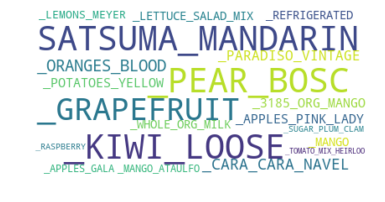

<img src="./img/2018/10/month.topic17.png">
Topic #18:
['BAGEL', '5290 WALNUTS', '4110 ORG RLD OATS', '5120 ORG ALMONDS', 'MILTON CHEDDAR', '6645 SUNFLWR SEEDS', '5150 BRAZIL NUTS', '5250 ORG PECAN HA', '3185 ORG MANGO', '5180 WHOLE CASHEWS', 'LETTUCE SALAD MIX', 'ARUGULA LOOSE', 'REFRIGERATED', '4125 OG STL CUT OA', '3680 BAKERS CH FLO', 'SUGAR PLUM CLAM', '5452 ORG PNUT BUTR', '2195 ORG GARBANZO', '2180 ORG BLK BEANS', 'POTATOES GARNET']


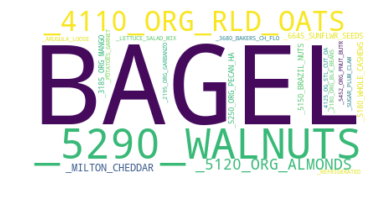

<img src="./img/2018/10/month.topic18.png">
Topic #19:
['CARROTS BUNCH', 'BLUEBERRIES', 'BEANS GREEN', 'RASPBERRY', 'BLACKBERRY PACK', 'TOMATO MIX HEIRLOO', 'BROCCOLI BABY SWEE', 'KIWI LOOSE', 'STRAWBERRY 1LB PKG', 'PEAR BOSC', 'LEMONS MEYER', 'MUSHROOMS SHIITAKE', 'HERBS BUNCH', 'LEEKS', 'MANGO', 'ORANGES BLOOD', 'POTATOES YELLOW', 'GRAPEFRUIT', 'ARUGULA LOOSE', 'BRUSSEL SPROUTS']


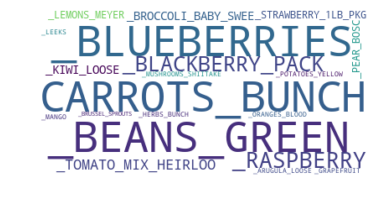

<img src="./img/2018/10/month.topic19.png">


In [71]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('./img/2018/10/month.topic%d.png'%topic_idx)
        print('<img src="./img/2018/10/month.topic%d.png">'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(items_set),n_top_words)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [42]:
topics3=topics.copy()

In [10]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
print(topic_compare)


[[20.  2.  8.  6.  1.  5.  5.  6.  6.  6.]
 [ 2. 20.  3.  3.  6.  2.  0.  1.  1.  2.]
 [ 8.  3. 20. 10.  4.  8.  5.  3.  8.  4.]
 [ 6.  3. 10. 20.  6.  5.  8.  4.  7.  2.]
 [ 1.  6.  4.  6. 20.  5.  6.  2.  1.  2.]
 [ 5.  2.  8.  5.  5. 20.  5.  6.  7.  5.]
 [ 5.  0.  5.  8.  6.  5. 20.  1.  2.  3.]
 [ 6.  1.  3.  4.  2.  6.  1. 20.  5.  6.]
 [ 6.  1.  8.  7.  1.  7.  2.  5. 20.  6.]
 [ 6.  2.  4.  2.  2.  5.  3.  6.  6. 20.]]


In [39]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [40]:
len(topics[0])

25

In [11]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

row 0
row 1
iI 0 Zuzu Eye Palette
iI 1 MUIR-DICED TOMATO
iI 2 BAMBU TONGS
iI 3 VERMONT QUARK
iI 4 HICKORY PRIMAL STR
iI 5 HY Headache 100t
iI 6 BIG D IVORY TAPER
iI 7 BLK MISSION FIG
iI 8 8360 BLK MACA ORG
iI 9 FRANTOIA EXTRA
iI 10 GD SPR HEMPS BURGR
iI 11 Epsom Salts Bulk
iI 13 ADHESIVE HOOKS
iI 14 CHARD KNOCK LIFE
iI 15 Avocado Shampoo
iI 17 OXO NYLON TURNER
iI 18 SR Amla 60vegcap
iI 19 NAGO GARLIC ONION
row 2
iI 0 RAW CREAM
iI 2 CITRUS TARTLETS
iI 5 TURN OFF PHONE
iI 6 Almond Facial Loti
iI 9 EC Milk Thistle 1o
iI 10 FB HairSkin Nail 1
iI 11 2405 KOSHER SALT
iI 13 MUIR-DICED TOMATO
iI 15 AIRSCENSE LAVENDER
iI 16 AL NOYA Curios WHT
iI 17 8067 BREATHE WELL
iI 19 SG Potassium 100ta
row 3
iI 0 UHarrys Hair Elixi
iI 1 EC Meno Spt 1oz
iI 2 AIRSCENSE LAVENDER
iI 4 8067 BREATHE WELL
iI 5 Gauze Pads 25ct
iI 7 SG Potassium 100ta
iI 8 Now Peppermint 16o
iI 9 8479 RED CLOVER WH
iI 11 2405 KOSHER SALT
iI 13 Almond Facial Loti
iI 14 BAMBU TONGS
iI 16 IH SPRTD PUMPKIN
iI 17 TBE GRANOLA 1LB
iI 19 G

array([10, 20])

In [42]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [225]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [231]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [233]:
ingredients.shape

(5, 55)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [244]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

array([[ 63.,  99.,  42.,  64., 112.,  14.,  21., 124.,  32.,  35.,  88.,
         68., 121., 130., 113., 120.,  38.,  95., 134.,  10.,  23.,  16.,
         27.,  41.,  96., 118.,  58., 101., 105.,  85.,  97.,  47.,  86.,
         29.,  20.,  91.,  15.,  55., 102.,  28.,  98.,   1., 119., 122.,
        132.,  11., 128.,  65.,  17.,  72.,  54.,   0.,  81., 125.,  25.],
       [100.,  32.,  64.,  19.,  88.,   1., 120.,  86.,   3.,   9.,  39.,
        105., 134.,  41.,  78.,  69.,  93., 131., 124.,  48.,  34.,  97.,
         67.,  57., 112.,  62.,  74.,   7.,  16.,  44., 115.,  91.,  65.,
         11., 123.,  14.,  68.,  53., 107.,  51.,  31.,   6.,  98., 102.,
         24., 121.,  61.,  49.,  55.,  12.,  82., 101., 133.,  60.,  75.],
       [ 37., 115.,  96.,  97.,  21.,   1.,  58.,  77.,  35.,   3., 105.,
        118.,  71., 130.,  85., 131., 104.,  87.,  19.,  15.,  43.,  38.,
        101.,   0.,  41.,   2.,  13., 127.,  62., 121.,  18.,  89.,  32.,
        102.,  50., 126.,  65.,  30.

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [43]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [44]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'SR Echinacea Purpu', 12.31, 1]
item: ['', 'Now Elderberry Ext', 12.0, 1]
item: ['', 'GINGER', 1.65, 12]
item: ['', 'KALE RED BOR', 2.49, 12]
item: ['', '8457 PSYLLIUM HUSK', 15.6, 31]
item: ['', 'CELERY', 4.87, 12]
item: ['', 'KALE RED RUSSIAN', 1.99, 12]
item: ['', '6556 DUTCH COCOA', 2.59, 16]
item: ['', 'LEMONS', 3.89, 12]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', 'COLLARDS', 2.49, 12]
item: ['', 'APPLE HONEYCRISP', 3.83, 12]
item: ['', 'SPROUTS ALFALFA', 2.59, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'GREEN CHARD', 1.99, 12]
item: ['', 'KALE GREEN', 1.99, 12]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'CHARD RED', 1.99, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'SPINACH BUNCHED', 2.99, 12]
item: ['', 'CUCUMBERS', 4.92, 12]
item: ['', 'BEETS RED LOOSE', 3.44, 12]
item: ['', 'KHC GRIZZLY CLAW', 10.89, 15]
item:

++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', '5357 SUNBUTTER', 15.82, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'APPLES PINK LADY', 6.31, 12]
item: ['', 'POTATOES YELLOW', 16.88, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'BANANAS', 12.81, 12]
item: ['', 'WW LAVASH', 2.89, 17]
item: ['', 'SAVORY BAKED TOFU', 45.24, 13]
item: ['', 'PURPLE SWT POTATO', 14.8, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'POTATOES RUSSET', 2.39, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'EGGPLANT GLOBE', 2.66, 12]
item: ['', 'ONIONS YELLOW', 0.9, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'LEEKS', 5.5600000000000005, 12]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'FAKIN BACON', 4.99, 13]
item: ['VD', 'FAKIN BACON', -4.99, 13]
item: ['', 'FAKIN BACON', 53.88, 13]
item: ['', 'CAULIFLOWER BULK', 11.18, 12]
ite

item: ['', 'TRADITIONAL TORTIL', 5.19, 17]
item: ['', 'SQUASH DELICATA', 2.29, 12]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 19.96, 6]
item: ['', 'PARSLEY CURLY', 1.99, 12]
item: ['', 'EGGS DZ ST JOHN', 7.29, 13]
item: ['', 'GARLIC WHITE', 1.4, 12]
item: ['', 'BEETS RED LOOSE', 1.6099999999999999, 12]
item: ['', 'KIWI LOOSE', 2.69, 12]
item: ['', 'TOMATOES ROMA', 2.67, 12]
item: ['', 'CELERY', 3.88, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['VD', 'FLAVORG VANILLA4oz', -15.49, 15]
item: ['', 'FENNEL', 2.03, 12]
item: ['', 'TOMATOES CLUSTER', 4.19, 12]
item: ['', 'MUSHROOM CRIMINI', 11.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', '2552 OLIVES wCUMI', 1.8599999999999999, 16]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', 'APPLES FUJI', 6.97, 12]
item: ['', 'HERB

item: ['', '3685 WW BREAD FLOU', 3.88, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.9500000000000001, 23]
item: ['', '2235 ORG BABY LIMA', 2.51, 16]
item: ['', 'WOOD ALMD BUTTER', 11.49, 15]
item: ['', 'STARTER Pastry', 3.49, 17]
item: ['', '5140 TAMARI ALMOND', 6.5600000000000005, 16]
item: ['', '6880 ORG CANE SUGA', 4.64, 16]
item: ['', 'EGGS ST JOHN 6 PK', 4.29, 13]
item: ['', '5670 SAFFLOWER OIL', 2.5300000000000002, 16]
item: ['', '5657 OG OLIVE OIL', 5.93, 16]
item: ['', 'ITALIAN SAUSAGE', 5.39, 13]
item: ['', '2863 BTR CHOC CHIP', 4.33, 16]
item: ['', '2430 KALAMATA OLIV', 4.05, 16]
item: ['', 'PEAR BOSC', 4.14, 12]
item: ['', 'ONIONS YELLOW', 0.5700000000000001, 12]
item: ['', 'GRAPEFRUIT', 7.9, 12]
item: ['', 'GARLIC WHITE', 1.33, 12]
item: ['', 'HERITAGE FLAKE bag', 9.99, 15]
item: ['', 'APPLES PINK LADY', 7.12, 12]
item: ['', 'APPLES FUJI', 6.73, 12]
item: ['', 'GINGER', 1.15, 12]
item: ['', 'FREY RED TABLE WIN', 9.99, 10]
item: ['', 'CAL OLIVE OIL

item: ['', '8556TURMERICCOCO', 11.04, 11]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'GINGER', 0.35000000000000003, 12]
++++++++++++++++++Topic #8, basket #4+++++++++++++++++++
item: ['', 'TOBYS TOFU DIP', 7.18, 13]
item: ['', 'Henna Gold Cond', 8.95, 4]
item: ['', 'Henna Gold Shampoo', 8.95, 4]
item: ['', 'GOPI PANEER', 6.89, 14]
item: ['', 'TOFURKY SPINA SAUS', 5.39, 13]
item: ['', 'GARD BEEFLESS BURG', 5.49, 19]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'SQUASH DELICATA', 7.32, 12]
item: ['', 'BUNCH SPINACH', 7.58, 12]
item: ['', 'PLAIN NAAN', 4.99, 17]
item: ['', 'CARROTS LOOSE', 2.05, 12]
item: ['', 'CALIFIA UNSWT', 4.69, 13]
item: ['', 'LARGE COOLER CRV', 0.1, 13]
item: ['', 'STRAU GREEK YOGURT', 8.69, 13]
item: ['', 'STRAUS PLN YOG QT', 5.39, 13]
item: ['', 'BEYOND BURGER', 6.69, 13]
item: ['', 'PARADISO VINTAGE', 5.22, 14]
item: ['', 'ITALIAN MONTASIO', 4.95, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]

item: ['', 'BAMBU PAN SCRAPER', 1.99, 6]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'AVOCADOS HASS', 1.6800000000000002, 12]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2448 CASTEL OLIVE', 3.6, 16]
item: ['', 'GOOD CULTR PINA', 1.79, 13]
item: ['', 'STICK INCENSE', 9.95, 8]
item: ['', 'Qualita Oro Espres', 9.59, 15]
item: ['', 'FRANK MYRRH', 9.95, 8]
item: ['', 'SOY CANDLE TRAVEL', 3.75, 7]
item: ['', 'ORANGES BLOOD', 1.04, 12]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'FLORAL SAGE BUNDLE', 10.25, 8]
item: ['', 'AROMATHERAPY TIN', 4.59, 7]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2458 PITD GRN OLIV', 3.42, 16]
item: ['', 'PEAR BOSC', 0.88, 12]
item: ['', 'LIMES', 0.6900000000000001, 12]
item: ['MR', 'SF Bag Charge', 0.4, 20]
++++++++++++++++++Topic #9, basket #10+++++++++++++++++++
item: ['', 'BL FlaxOil 32oz Li', 39.71, 1]
item: ['', 'BLACKBERRY SPREAD', 3.39, 15]
item: ['', 'Unsalted Virginia', 6.29, 15]
item: ['MP', 'BA

item: ['', 'LL TOFU PUPS', 4.29, 13]
item: ['', 'FROZEN SOBA NOODLE', 5.59, 19]
item: ['', 'OG KETCHUP', 4.49, 15]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', '3120 DRD APRICOT', 13.96, 16]
item: ['', 'AVOCADOS HASS', 7.62, 12]
item: ['', 'SQUASH ZUCCHINI', 2.91, 12]
item: ['', 'MUSHROOMS KING TRU', 11.05, 12]
item: ['', 'MEDIUM TOFU', 2.39, 13]
item: ['', '5 LB SUSHI RICE', 11.59, 16]
item: ['', 'BOK CHOY BABY', 3.23, 12]
item: ['', 'GINGER PEACH GREEN', 2.99, 15]
++++++++++++++++++Topic #11, basket #4+++++++++++++++++++
item: ['', 'Bulk Soap', 1.9500000000000002, 4]
item: ['', 'BEANS GREEN', 1.35, 12]
item: ['', 'DILL', 2.99, 12]
item: ['', 'CABBAGE GREEN', 1.76, 12]
item: ['', 'LEEKS', 1.67, 12]
item: ['', 'DAIKON', 1.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', 'CELERY', 1.18, 12]
item: ['', 'CADIA TOM PASTE', 1.3900000000000001, 15]
item: ['', 'BEETS RED LOOSE', 3.1, 12]
item: ['', 'SQUASH ZUCCHINI', 1.92, 12]
item

item: ['', 'RASPBERRY', 6.99, 12]
item: ['', 'SUGAR PLUM CLAM', 1.99, 12]
item: ['', 'BROCCOLI BABY SWEE', 3.29, 12]
item: ['', 'BANANAS', 1.45, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'AVOCADOS HASS', 4.79, 12]
item: ['', 'TOMATO MIX HEIRLOO', 10.68, 12]
item: ['', 'POTATOES YELLOW', 1.24, 12]
item: ['', 'PEAR BOSC', 0.76, 12]
item: ['', 'POTATOES RED', 1.18, 12]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #13, basket #2+++++++++++++++++++
item: ['', 'AMY RED CURRY THAI', 6.09, 19]
item: ['', 'AMY GRN CURRY ENTR', 6.09, 19]
item: ['', 'BLACK BEAN ENCHILA', 6.09, 19]
item: ['', 'AMY MATTAR TOFU', 6.09, 19]
item: ['', 'CONV GALLON CLOVER', 5.09, 13]
item: ['', 'SAVVY SANDWICH', 4.59, 13]
item: ['', 'CHEESE ENCHILAD ME', 6.09, 19]
item: ['', 'AMY MATTAR PANEER', 6.09, 19]
item: ['', '10% GREEK YOGURT', 8.29, 13]
item: ['', 'FILTER CONE', 2.99, 6]
item: ['', 'BAGEL', 5.0, 17]
item: ['', 'BOK CHOY', 4.72, 12]
item: ['', 'YAYAS CHEESE POPCO', 5.38, 15]
item: ['', '

item: ['', 'RN Extra 50B Go 30', 33.99, 1]
item: ['', 'CSECRET AMINOS 8oz', 5.99, 15]
item: ['', 'GRAPEFRUIT', 3.16, 12]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'POTATOES YELLOW', 3.5300000000000002, 12]
item: ['', 'EDEN BLACKBEANS 15', 2.39, 15]
item: ['', 'NORDIC OMEGA 3 PET', 15.99, 7]
item: ['', 'EZ DGL Sugarless 1', 12.95, 1]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'THAI COCONUT MILK', 2.49, 15]
item: ['', 'COOMBS AMBER 12 OZ', 10.39, 15]
item: ['', 'CP BEEF JERKY', 4.99, 7]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'NEWMANS BEEF JERKY', 6.49, 7]
item: ['', 'AVOCADOS HASS', 1.8399999999999999, 12]
item: ['', 'CHAO ORIGINAL', 5.79, 14]
item: ['', 'ASPARAGUS', 6.99, 12]
item: ['', '5140 TAMARI ALMOND', 8.15, 16]
item: ['', 'HERBS BUNCH', 1.69, 12

item: ['', 'RAISED DONUT', 2.69, 17]
item: ['MP', 'BAG CREDIT', -0.1, 23]
item: ['MP', 'BAG CREDIT', -0.1, 23]


In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

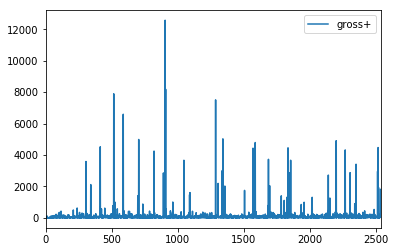

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [54]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [1]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

NameError: name 'get_dataframe' is not defined

In [11]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

['/Users/Sarah/galvanize/dsi-capstone/jsons/201802/0.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/1.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/2.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/3.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/4.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/5.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/6.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/7.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/8.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/9.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/10.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/11.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/12.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/13.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/14.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/15.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802

In [10]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

ValueError: Expected object or value